**1. Find QDs** 

Written by Jessica Kline and Mummar Yaman

This code is the first step in analyzing widefield blinking videos. It reads in blinking videos of file type ".ome.tif" and retuns a ".png" showing the selected QDs along with a ".csv" containing a stack of blinking traces from the selected QDs.

Particle selection occurs by using Laplacian of Gaussian [LoG](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.blob_log) method. You can find detail explanation from the [link](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_blob.html).

In [ ]:
#@title Install Library
#for Google Colab, we need to downgrade the pyyaml 
!pip install pyyaml==5.4.1
!pip install aicsimageio

In [ ]:
#@title Import Function
import sys
import os
import numpy as np
from aicsimageio import AICSImage, imread

import os
import pandas as pd

import cv2
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean

!pip install matplotlib-scalebar
from matplotlib_scalebar.scalebar import ScaleBar

import ipywidgets as widgets

In [ ]:
#@title Particle Picking Functions
#Written by Muammer Yaman

def particle_finder_oem_data(oem_data, min_sigma=1,max_sigma=10, threshold=0.02,overlap=0.2,radius=20):
  '''
  finding particle positons in oem data using Laplacian of Gaussian
  input
  oem_data: oem data 
  min_sigma: scalar or sequence of scalars, optional
  max_sigma: scalar or sequence of scalars, optional
  threshold:float or None, optional
  radius: radius of the mask, optinal. The 
  output
  dictonary of each particle positions
  '''
  
  coord_dict_new_hyper= {}


  max_cont=oem_data.mean(axis=0)
  max_cont = 255*(max_cont-max_cont.min())/(max_cont.max()-max_cont.min())
  max_cont = max_cont.astype('uint8')
  image = max_cont
  # image = rescale(image, 0.25, anti_aliasing=False)
  image = image.astype('uint8')

  image_gray = image

  #remove bigger particles 
  blobs_log_bigger = blob_log(image_gray, min_sigma=max_sigma, threshold=threshold,overlap=overlap) #0.2 for image
  # draw filled circles in white on black background as masks
  mask1 = np.zeros((image_gray.shape))
  radius=radius
  for i in range(len(blobs_log_bigger)):
    xc,yc=int(blobs_log_bigger[i,1]),int(blobs_log_bigger[i,0])
    mask1=cv2.circle(mask1,(xc,yc),radius,255,-1)

  blobs_log = blob_log(image_gray, min_sigma=min_sigma,max_sigma=max_sigma, threshold=threshold,overlap=overlap) #0.2 for image

  # Compute radii in the 3rd column.
  blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

  loc_dict = {}
  j = 0

  for c in range(blobs_log.shape[0]):
    # print(blobs_log[c][0], blobs_log[c][1])
    y, x =[blobs_log[c][0], blobs_log[c][1]]
    if mask1[int(y),int(x)] !=255:
      loc_dict[j] = [blobs_log[c][0], blobs_log[c][1]]
      j = j+1

  coord_dict_new_hyper = loc_dict
  return coord_dict_new_hyper


def particle_show(image_par,loc_particles, parent_folder, name):
  '''
  image_par:selected area of image
  loc_particles:information of particle location, should include x and y coordinates
  '''
  fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=False)
  # ax = axes.ravel()
  ax=axes
  num_par=0
  ax[0].imshow(image_par)
  for im in plt.gca().get_images():
    im.set_clim(100, 120)
  ax[0].set_title('Original Image',fontsize=24)
  ax[1].set_title('Particle Finder',fontsize=24)
  for idx in range(len(loc_particles)):
      

      clr = ax[1].imshow(image_par)
      r=2
      y, x = loc_particles[idx]
      c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
      ax[1].add_patch(c)
      ax[1].text(x+5, y+5, str(num_par), c='white', fontsize = 12)
      num_par +=1
      # ax[idx].set_axis_off()

  for im in plt.gca().get_images():
    im.set_clim(100, 120)
  plt.tight_layout()

  file_directory = parent_folder+'analyzed_data/particle_picking/images/'

  plt.savefig(file_directory+name+".png", bbox_inches = 'tight')
  plt.show()
  return

def Spectra_Window(hyper_image, xpos, ypos,spec_window_size=4):
    #Returns the portion of the image within the window given the
    #hyper_image (imgsrc), the xposition and the yposition
    spectra= hyper_image[:,int(xpos-spec_window_size/2):int(xpos+spec_window_size/2), 
                    int(ypos-spec_window_size/2):int(ypos+spec_window_size/2)].mean(axis=(1,2))
    return spectra

def Image_Window(hyper_image, xpos, ypos,im_window_size=16):
    #Returns the portion of the image within the window given the
    #hyper_image (imgsrc), the xposition and the yposition
    image= hyper_image[int(xpos-im_window_size/2):int(xpos+im_window_size/2), 
                    int(ypos-im_window_size/2):int(ypos+im_window_size/2)]
    return image

def particle_info_stack(hyper_img,loc_particles,spec_window_size=4,im_window_size=16):
  '''
  input:
  hyper_img:oem data to analysis
  loc_particles:information of particle location, should include x and y coordinates
  spec_window_size:scalar, optional
  im_window_size:scalar, optinal
  output:
  stack of coordinate, spectrum and image of each particle
  coord_stack: stack of coordinate of each particle
  spectra_stack:stack of spetrum of each particle
  image: stack of an image of each particle
  '''
  image_stack = np.zeros((im_window_size,im_window_size))
  image_mean=hyper_img.mean(axis=0)
  time=hyper_img.shape[0]
  coord_stack = np.zeros((2))
  spectra_stack=np.zeros((time))

  for j in range(len(loc_particles)):
    xc,yc=loc_particles[j][0:2]
    one_spectra=Spectra_Window(hyper_img,xc,yc,spec_window_size=spec_window_size)
    one_particle=Image_Window(image_mean,xc,yc,im_window_size=im_window_size)
    if one_particle.shape[0] ==16 & one_particle.shape[1]==16:
      coord_stack = np.vstack((coord_stack, loc_particles[j][0:2]))
      spectra_stack=np.vstack((spectra_stack,one_spectra))
      image_stack = np.dstack((image_stack, one_particle))

  coord_stack = coord_stack[1:,:]
  spectra_stack=spectra_stack[1:,]
  image_stack = image_stack[:,:,1:]
  image_stack = np.swapaxes(image_stack, 0, 2)
  return coord_stack,spectra_stack,image_stack

Connect your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

This code expects the following file tree:
1. parent_folder = directory_path/Large Data Folder/ (where large data folder is for example all videos collected on May 12th)
2. folder_path = directory_path/Large Data Folder/Data Folder 1/ (where data folder 1 is for example the 1st video collected on May 12th)

The code creates the following file tree:
1. directory_path/Large Data Folder/analyzed_data/ (stores all the analyzed data)
2. directory_path/Large Data Folder/analyzed_data/particle_picking/ (save folder for the data associated with selecting the QDs from the videos)
3. directory_path/Large Data Folder/analyzed_data/particle_picking/images/ (save folder for the final particle picking images)
4. directory_path/Large Data Folder/analyzed_data/particle_picking/traces/ (save folder for the blinking traces extracted from the video)

In [ ]:
## FILE SET UP

parent_folder = "//InsertYourPathHere//"        #overarching folder containing roi's remember to add the / for the end of path
folder_path = "//InsertYourPathHere//"   #folder of roi .ome.tiff has_1 in path

name = "//InsertYourDataNameHere//"   #name of roi    #DO NOT INCLUDE .ome.tif EXTENSION IN NAME

file_directory= parent_folder+'analyzed_data/' #create save folder file
if os.path.exists(file_directory) == False:
  os.mkdir(file_directory)

file_directory= parent_folder+'analyzed_data/particle_picking/' #create save folder file
if os.path.exists(file_directory) == False:
  os.mkdir(file_directory)

file_directory= parent_folder+'analyzed_data/particle_picking/images/' #create save folder file
if os.path.exists(file_directory) == False:
  os.mkdir(file_directory)

file_directory= parent_folder+'analyzed_data/particle_picking/traces/' #create save folder file
if os.path.exists(file_directory) == False:
  os.mkdir(file_directory)

## set these dimensions to select particles in a certain area
# bounds of [0, -1] will analyze the whole imaged area
y_dim = [0, -1]
x_dim = [0, -1]


In [ ]:
## READ IN ROI ##

img_video = AICSImage(folder_path + name +".ome.tif")
img_video=img_video.data.squeeze()
img_video.shape

(8000, 751, 742)

In [ ]:
## if the ROI is not square crop it to be square ##

len1 = len(img_video[0,:,0])
len2 = len(img_video[0,0,:])
if not (len1 == len2):
  crop_len = np.amin([len1, len2])
  img_video = img_video[:,0:crop_len,0:crop_len]

In [ ]:
## ESTABLISH BACKGROUND OF IMAGE ##
# we've found that the particle picking method struggles when the particles are very close to the background (ie our QDs which are ~ 3-10 counts/50ms above background on average)
# this block calculated what the actuall background of the image is so that we can address this picking issue later on

start_val = np.amin([x_dim[0], y_dim[0]])
end_val = np.amax([x_dim[1], y_dim[1]])

f_list = np.arange(start_val,end_val ,25)   #list of pixel slices to use for backgrounding
j = np.zeros(len(img_video[0,:,0]))
temp_avg = img_video.mean(axis=0)


# take the average of the horizontal and vertical slices in established list
for f in f_list:
  j+= temp_avg[:, f]
  j+= temp_avg[f,:].T

j /= (len(f_list)*2)


background_val = np.mean(j)+ 3*np.std(j)   #background is mean + 3 std dev of the average image slice
print(background_val)
plt.plot(temp_avg[:, 300][start_val:end_val])
plt.plot(j[start_val:end_val])
plt.plot([0,end_val-start_val],[background_val,background_val])
plt.legend(['horz. slice 300', 'average slice', 'background value'])

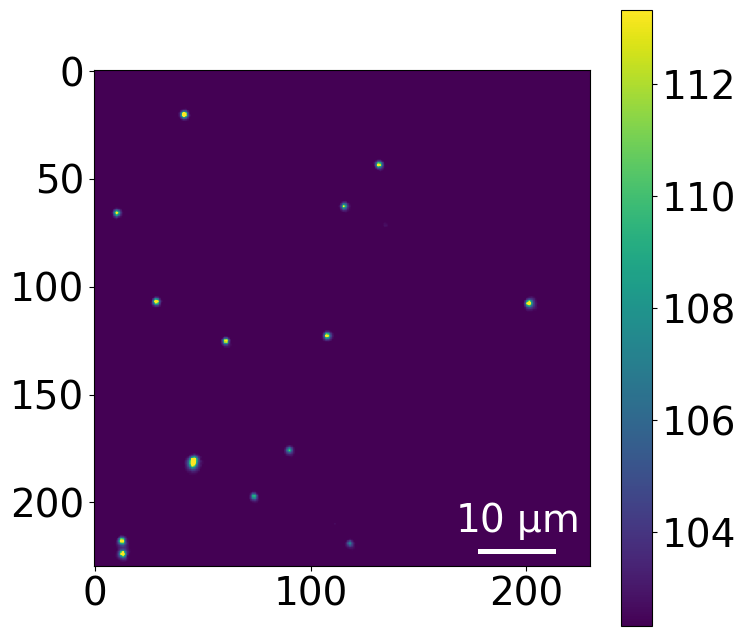

In [ ]:
## plot the relvent area of the ROI scaled around the background

ff = plt.figure()
ff.set_figwidth(8)
ff.set_figheight(8)
plt.imshow(temp_avg[y_dim[0]:y_dim[1],x_dim[0]:x_dim[1]]) #Use Dimensions to clip images to microscope FoV 
plt.colorbar()
plt.clim(background_val-1, background_val+10) #sets color scale, empty min max values plane fit

scalebar1 = ScaleBar(11/40, 'um', box_color = "None", location = 'lower right', scale_loc = "top" ,color = 'w') # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar1)

In [ ]:
##set the value of pixels less than the background to zero (provides contrast for the picking algorithim)

z = np.zeros(len(img_video[:,0,0]))
for r in range(y_dim[0],y_dim[1]):
  for c in range(x_dim[0],x_dim[1]):
    if temp_avg[r,c] < background_val:
      img_video[:,r,c] = z

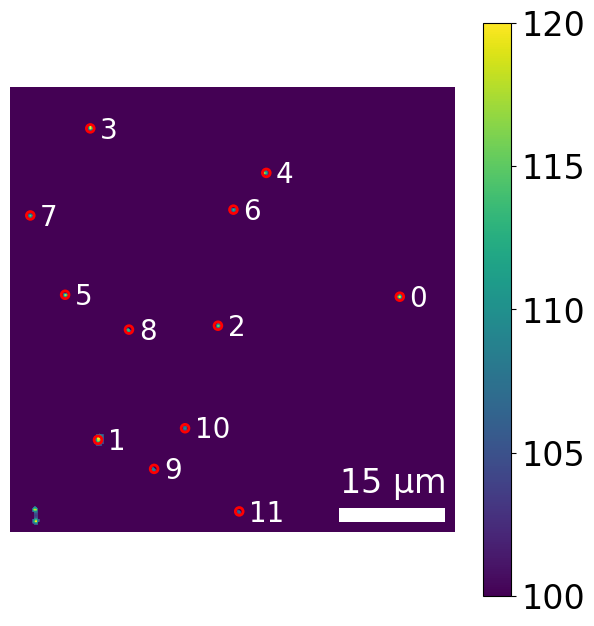

In [ ]:
#choose selected area from full image
selected_area=img_video[:,y_dim[0]:y_dim[1],x_dim[0]:x_dim[1]]  #y by x

#use particles finder dunction to find particle location
loc_particles=particle_finder_oem_data(selected_area,min_sigma=2,max_sigma=30, threshold=0.02,overlap=0.1,radius=50)  #increase min_sigma to ~2-3

#create a mean image
image_par=selected_area.mean(axis=0)

#show orginal image and image with particle information
particle_show(image_par,loc_particles,parent_folder, name)
coord_stack,spectra_stack,image_stack=particle_info_stack(selected_area,loc_particles,spec_window_size=2,im_window_size=16)


In [ ]:
##check list for bad selections - ie hot background pixels or clusters

max_allowable_I = np.mean(np.mean(spectra_stack, axis = 1)) + 2*np.std(np.mean(spectra_stack, axis = 1))
max_allowable_I2 = np.mean(np.mean(spectra_stack, axis = 1)) + 3*np.std(np.mean(spectra_stack, axis = 1))
sn_list = []
max_list = []
min_list = []
n = 0
while n < len(spectra_stack):
  if np.amax(spectra_stack[n,:]) < background_val:        # checks for hot background pixels
    spectra_stack = np.delete(spectra_stack, n, axis = 0)
  elif np.mean(spectra_stack[n,:]) > max_allowable_I or np.amax(spectra_stack[n,:]) >max_allowable_I2 :     # checks for clusters
    spectra_stack = np.delete(spectra_stack, n, axis = 0)
  else:
    sn_list.append(np.amax(spectra_stack[n,:])/np.amin(spectra_stack[n,:]))
    max_list.append(np.amax(spectra_stack[n,:]))
    min_list.append(np.amin(spectra_stack[n,:]))
    n = n+1

print([background_val,max_allowable_I, np.mean(min_list),np.mean(max_list),np.mean(sn_list)])

In [ ]:
## plots all of the particle picked spectra

ff = plt.figure();
ff.set_figwidth(5)
ff.set_figheight(1*len(spectra_stack))

for n in range(0, len(spectra_stack)):
  plt.subplot(len(spectra_stack),1,n+1)
  plt.plot(spectra_stack[n,:])
  plt.text(0.99, 0.7, n, fontsize = 'large', horizontalalignment='right',
  verticalalignment='center', transform=plt.gca().transAxes)

**Saving All Outputs:**


In [ ]:
file_name= name+'.csv' #identify ROI in new file name
file_directory = parent_folder+'analyzed_data/particle_picking/traces/'

coord_spectra_stack = spectra_stack
pd.DataFrame(coord_spectra_stack.T).to_csv(os.path.join(file_directory,file_name))